In [28]:
from pymongo import MongoClient
import dotenv
import os
import redis
import json
import time
import matplotlib.pyplot as plt
import numpy as np

dotenv.load_dotenv()
# Make sure to replace the connection string with your own
client = MongoClient(os.getenv('MONGO_HOST'))

db = client['sample_mflix']
movies = db['movies']
cache = db['cache']

# connect to redis
redis_client = redis.StrictRedis(host='redis-10134.c326.us-east-1-3.ec2.cloud.redislabs.com',
                                 port=10134,
                                 password=os.getenv('REDIS_PASS'))

In [29]:
def top_n_comments(n_count, start_year, end_year):
    # create a cache key to get records quickly
    cache_key = 'top_{}_comments_between_{}_{}'.format(n_count, start_year, end_year)

    redis_result = redis_client.get(cache_key)
    if redis_result is not None:
        return json.loads(redis_result), 200

    # check if the result is in mongo cache collection
    mongo_cache_result = cache.find_one({'key': cache_key})
    if mongo_cache_result is not None:
        return json.loads(mongo_cache_result['value']), 200

    top_movies = mongo_pipeline_exicute(n_count, start_year, end_year)

    # save the result in redis cache
    redis_client.set(cache_key, json.dumps(top_movies))
    # save the result in mongo cache collection
    cache.insert_one({'key': cache_key, 'value': json.dumps(top_movies)})
    return (top_movies), 200


def top_n_comments_no_redis_cache(n_count, start_year, end_year):
    # create a cache key to get records quickly
    cache_key = 'top_{}_comments_between_{}_{}'.format(n_count, start_year, end_year)

    # check if the result is in mongo cache collection
    mongo_cache_result = cache.find_one({'key': cache_key})
    if mongo_cache_result is not None:
        return json.loads(mongo_cache_result['value']), 200

    top_movies = mongo_pipeline_exicute(n_count, start_year, end_year)

    # save the result in mongo cache collection
    cache.insert_one({'key': cache_key, 'value': json.dumps(top_movies)})
    return (top_movies), 200


def top_n_comments_no_cache(n_count, start_year, end_year):

    top_movies = mongo_pipeline_exicute(n_count, start_year, end_year)

    return top_movies, 200


def mongo_pipeline_exicute(n_count, start_year, end_year):
    # MongoDB aggregation pipeline to group by movie_id and count the comments
    pipeline = [
        {"$match": {
            "num_mflix_comments": {"$exists": True, "$ne": 0},  # Filter out movies with no comments
            "year": {"$gte": start_year, "$lte": end_year}  # Filter movies based on the release year range
        }},
        {"$project": {
            "title": 1,
            "year": 1,
            "num_comments": "$num_mflix_comments",
        }},  # Project title, year, and number of comments
        {"$sort": {"num_comments": -1}},  # Sort documents by the number of comments in descending order
        {"$limit": n_count}  # Limit the result to the top 10 documents
    ]

    top_movies = list(movies.aggregate(pipeline))
    # replace ObjectId with string
    for movie in top_movies:
        movie['_id'] = str(movie['_id'])

    return top_movies

In [30]:
# run each function 100 times to get a list of their response times
top_n_comments_response_times = []
top_n_comments_no_redis_cache_response_times = []
top_n_comments_no_cache_response_times = []

for i in range(101):
    start_time = time.time()
    top_n_comments(10, 2000, 2010)
    end_time = time.time()
    top_n_comments_response_times.append(end_time - start_time)

    start_time = time.time()
    top_n_comments_no_redis_cache(10, 2000, 2010)
    end_time = time.time()
    top_n_comments_no_redis_cache_response_times.append(end_time - start_time)

    start_time = time.time()
    top_n_comments_no_cache(10, 2000, 2010)
    end_time = time.time()
    top_n_comments_no_cache_response_times.append(end_time - start_time)

In [31]:
# drop the first result as it is an outlier
top_n_comments_response_times = top_n_comments_response_times[1:]
top_n_comments_no_redis_cache_response_times = top_n_comments_no_redis_cache_response_times[1:]
top_n_comments_no_cache_response_times = top_n_comments_no_cache_response_times[1:]

In [32]:
# calculate the average response time for each function
top_n_comments_avg_response_time = sum(top_n_comments_response_times) / len(top_n_comments_response_times)
top_n_comments_no_redis_cache_avg_response_time = sum(top_n_comments_no_redis_cache_response_times) / len(top_n_comments_no_redis_cache_response_times)
top_n_comments_no_cache_avg_response_time = sum(top_n_comments_no_cache_response_times) / len(top_n_comments_no_cache_response_times)

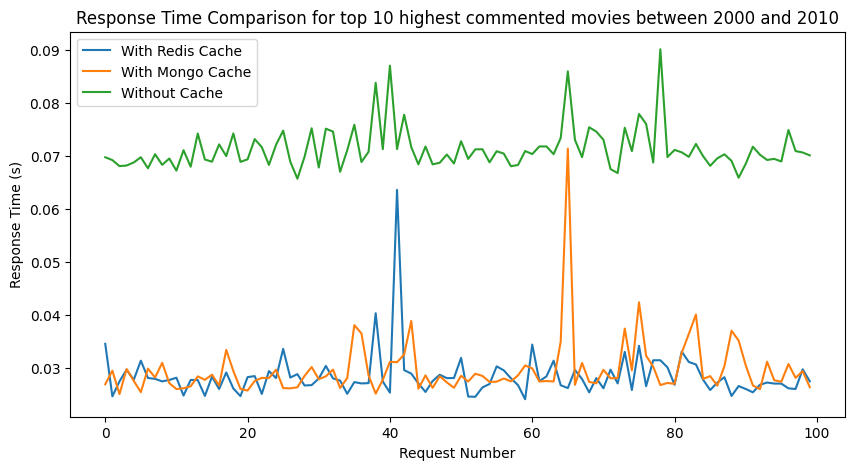

In [33]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(top_n_comments_response_times, label='With Redis Cache')
plt.plot(top_n_comments_no_redis_cache_response_times, label='With Mongo Cache')
plt.plot(top_n_comments_no_cache_response_times, label='Without Cache')
plt.xlabel('Request Number')
plt.ylabel('Response Time (s)')
plt.title('Response Time Comparison for top 10 highest commented movies between 2000 and 2010')
plt.legend()
# save fig
plt.savefig('response_time_comparison_10.png')
plt.show()

In [34]:
# get the average, 50th Percentile, 90th Percentile
print('With Redis Cache')
print('Average Response Time: {}'.format(top_n_comments_avg_response_time))
print('50th Percentile: {}'.format(np.percentile(top_n_comments_response_times, 50)))
print('90th Percentile: {}'.format(np.percentile(top_n_comments_response_times, 90)))
print('Without Redis Cache')
print('Average Response Time: {}'.format(top_n_comments_no_redis_cache_avg_response_time))
print('50th Percentile: {}'.format(np.percentile(top_n_comments_no_redis_cache_response_times, 50)))
print('90th Percentile: {}'.format(np.percentile(top_n_comments_no_redis_cache_response_times, 90)))
print('Without Cache')
print('Average Response Time: {}'.format(top_n_comments_no_cache_avg_response_time))
print('50th Percentile: {}'.format(np.percentile(top_n_comments_no_cache_response_times, 50)))
print('90th Percentile: {}'.format(np.percentile(top_n_comments_no_cache_response_times, 90)))

With Redis Cache
Average Response Time: 0.028356361389160156
50th Percentile: 0.027638554573059082
90th Percentile: 0.031369471549987794
Without Redis Cache
Average Response Time: 0.029521543979644776
50th Percentile: 0.028044819831848145
90th Percentile: 0.03491668701171875
Without Cache
Average Response Time: 0.07122607946395874
50th Percentile: 0.0702512264251709
90th Percentile: 0.07517027854919434


In [35]:
# run each function 100 times to get a list of their response times
top_n_comments_response_times = []
top_n_comments_no_redis_cache_response_times = []
top_n_comments_no_cache_response_times = []

for i in range(101):
    start_time = time.time()
    top_n_comments(100, 1955, 2020)
    end_time = time.time()
    top_n_comments_response_times.append(end_time - start_time)

    start_time = time.time()
    top_n_comments_no_redis_cache(100, 1955, 2020)
    end_time = time.time()
    top_n_comments_no_redis_cache_response_times.append(end_time - start_time)

    start_time = time.time()
    top_n_comments_no_cache(100, 1955, 2020)
    end_time = time.time()
    top_n_comments_no_cache_response_times.append(end_time - start_time)

In [36]:
# drop the first result as it is an outlier
top_n_comments_response_times = top_n_comments_response_times[1:]
top_n_comments_no_redis_cache_response_times = top_n_comments_no_redis_cache_response_times[1:]
top_n_comments_no_cache_response_times = top_n_comments_no_cache_response_times[1:]

In [37]:
# calculate the average response time for each function
top_n_comments_avg_response_time = sum(top_n_comments_response_times) / len(top_n_comments_response_times)
top_n_comments_no_redis_cache_avg_response_time = sum(top_n_comments_no_redis_cache_response_times) / len(top_n_comments_no_redis_cache_response_times)
top_n_comments_no_cache_avg_response_time = sum(top_n_comments_no_cache_response_times) / len(top_n_comments_no_cache_response_times)

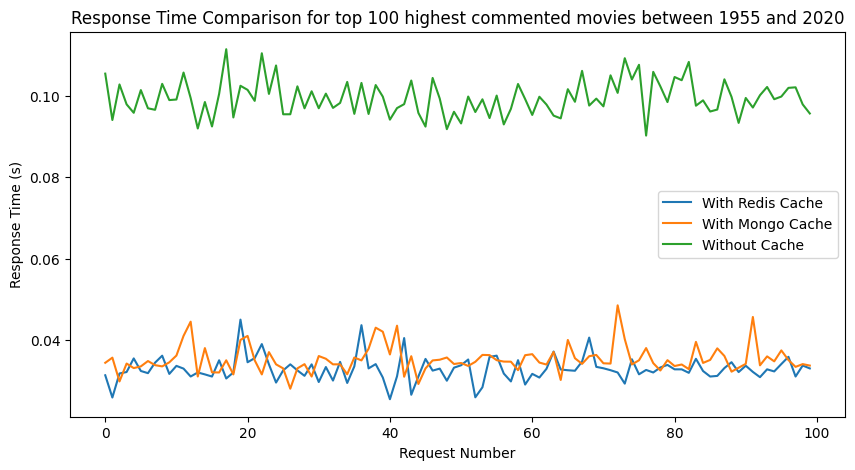

In [38]:
#plot the results
plt.figure(figsize=(10, 5))
plt.plot(top_n_comments_response_times, label='With Redis Cache')
plt.plot(top_n_comments_no_redis_cache_response_times, label='With Mongo Cache')
plt.plot(top_n_comments_no_cache_response_times, label='Without Cache')
plt.xlabel('Request Number')
plt.ylabel('Response Time (s)')
plt.title('Response Time Comparison for top 100 highest commented movies between 1955 and 2020')
plt.legend()
# save fig
plt.savefig('response_time_comparison_100.png')
plt.show()

In [39]:
# get the average, 50th Percentile, 90th Percentile
print('With Redis Cache')
print('Average Response Time: {}'.format(top_n_comments_avg_response_time))
print('50th Percentile: {}'.format(np.percentile(top_n_comments_response_times, 50)))
print('90th Percentile: {}'.format(np.percentile(top_n_comments_response_times, 90)))
print('Without Redis Cache')
print('Average Response Time: {}'.format(top_n_comments_no_redis_cache_avg_response_time))
print('50th Percentile: {}'.format(np.percentile(top_n_comments_no_redis_cache_response_times, 50)))
print('90th Percentile: {}'.format(np.percentile(top_n_comments_no_redis_cache_response_times, 90)))
print('Without Cache')
print('Average Response Time: {}'.format(top_n_comments_no_cache_avg_response_time))
print('50th Percentile: {}'.format(np.percentile(top_n_comments_no_cache_response_times, 50)))
print('90th Percentile: {}'.format(np.percentile(top_n_comments_no_cache_response_times, 90)))

With Redis Cache
Average Response Time: 0.032859783172607425
50th Percentile: 0.03259110450744629
90th Percentile: 0.03555877208709717
Without Redis Cache
Average Response Time: 0.035243880748748777
50th Percentile: 0.03464019298553467
90th Percentile: 0.040000104904174806
Without Cache
Average Response Time: 0.09950345039367675
50th Percentile: 0.0992124080657959
90th Percentile: 0.10513956546783447
